# Project 2:  Ames Housing Data


## Problem Statement

- Is it clear what the student plans to do?
- What type of model will be developed?
- How will success be evaluated?
- Is the scope of the project appropriate?
- Is it clear who cares about this or why this is important to investigate?
- Does the student consider the audience and the primary and secondary stakeholders?


__If you're a homeowner and is currently considering to sell your house, how do you know what is the right price to ask for?__

__In this project, we will find out which features of the house are the most important in predicting the sale prices of the houses in the Ames Housing Dataset. In particularly, which features have the highest correlation with our target - SalePrice. We will be running Linear, Lasso and Ridge regressions to find the features which contributes the most to the sale prices and to understand if these features will result in a rise or drop in sale prices.__

__The results of this project will give homeowners a better idea of how much they can sell their houses for based on the features of their home.__

All libraries will be added here 

In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

## Import Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train = train.drop(['PID'],axis =1)
test = test.drop(['PID'],axis =1)

In [4]:
print(train.shape)
print(test.shape)

(2051, 80)
(879, 79)


## EDA

Merge train and test dataset for EDA

- what missing values means
- figure out what each categorical value represents
- identify outliers
- consider whether discrete values are better represented as categorical or continuous. (Are relationship to target linear?)

In [5]:
# To combine train and test dataset to clean up the dataset together
total = pd.concat([train,test],sort=False)

In [6]:
total.shape

(2930, 80)

In [7]:
total.isnull().sum().sort_values(ascending=False)

Pool QC            2917
Misc Feature       2824
Alley              2732
Fence              2358
Fireplace Qu       1422
SalePrice           879
Lot Frontage        490
Garage Qual         159
Garage Cond         159
Garage Yr Blt       159
Garage Finish       159
Garage Type         157
Bsmt Exposure        83
BsmtFin Type 2       81
Bsmt Cond            80
Bsmt Qual            80
BsmtFin Type 1       80
Mas Vnr Type         23
Mas Vnr Area         23
Bsmt Full Bath        2
Bsmt Half Bath        2
Garage Cars           1
Electrical            1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Garage Area           1
Lot Shape             0
Street                0
                   ... 
Condition 1           0
Heating               0
Exter Cond            0
Foundation            0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
3Ssn Porch            0
Enclosed Porch  

col         28
null        28
dtypes      28
per_null    28
dtype: int64


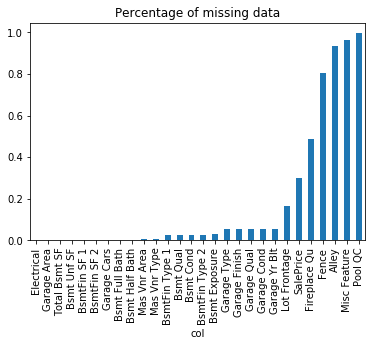

In [8]:
total_null = pd.DataFrame(zip(total.columns, total.isnull().sum(), total.dtypes, ), columns=['col','null','dtypes'],index=total.columns )
total_null = total_null[total_null['null'] > 0].sort_values(by = 'null')
total_null['per_null'] = total_null['null']/len(total)
total_null['per_null'].plot(kind='bar',)
plt.title('Percentage of missing data')
plt.xlabel('col')
print(total_null.count())
#index=train.columns

Note: not to replace saleprice with 0 - to split into cleaned train and test sets later on

In [9]:
total_null['per_null'].sort_values(ascending=False)

Pool QC           0.995563
Misc Feature      0.963823
Alley             0.932423
Fence             0.804778
Fireplace Qu      0.485324
SalePrice         0.300000
Lot Frontage      0.167235
Garage Yr Blt     0.054266
Garage Cond       0.054266
Garage Qual       0.054266
Garage Finish     0.054266
Garage Type       0.053584
Bsmt Exposure     0.028328
BsmtFin Type 2    0.027645
BsmtFin Type 1    0.027304
Bsmt Cond         0.027304
Bsmt Qual         0.027304
Mas Vnr Type      0.007850
Mas Vnr Area      0.007850
Bsmt Half Bath    0.000683
Bsmt Full Bath    0.000683
Garage Cars       0.000341
BsmtFin SF 2      0.000341
BsmtFin SF 1      0.000341
Bsmt Unf SF       0.000341
Total Bsmt SF     0.000341
Garage Area       0.000341
Electrical        0.000341
Name: per_null, dtype: float64

There are 28 variables with missing data, and 4 variables with more than 50% missing. It seemed that most variables have missing values because the house do not have those attributes (i.e. house do not have pool, basement, fence, alley etc. and hence is not applicable in that scenario). Will not be replacing missing saleprice as these are rows from the test set.

In [10]:
total['SalePrice'].notna().sum()

2051

In [11]:
total['SalePrice'].isnull().sum()

879

In [12]:
total[total['SalePrice'].isnull()].shape #split using this col later on 

(879, 80)

## Data Cleaning

- Decide how to impute null values.
- Decide how to handle outliers.
- Do you want to combine any features?
- Do you want to have interaction terms?
- Do you want to manually drop collinear features?

### Imputing null values for categorical variables with missing values

In [13]:
categorical = [i for i in total.select_dtypes(include=['object']).columns if total[str(i)].isnull().sum() > 0 ]
categorical.remove('Electrical')
for col in categorical:
    total[col].fillna('NA', inplace=True) #replace na with NA
    print(col, ':', total[col].isnull().sum()) #check if there is still null values

Alley : 0
Mas Vnr Type : 0
Bsmt Qual : 0
Bsmt Cond : 0
Bsmt Exposure : 0
BsmtFin Type 1 : 0
BsmtFin Type 2 : 0
Fireplace Qu : 0
Garage Type : 0
Garage Finish : 0
Garage Qual : 0
Garage Cond : 0
Pool QC : 0
Fence : 0
Misc Feature : 0


In [14]:
# Fill NA with the most popular value.
total['Electrical'] = total['Electrical'].fillna(total['Electrical'].mode()[0])

In [15]:
total['Mas Vnr Type'].value_counts()

None       1752
BrkFace     880
Stone       249
BrkCmn       25
NA           23
CBlock        1
Name: Mas Vnr Type, dtype: int64

According to the data dictionary, these are the categories of Mas Vnr Type.

Mas Vnr Type (Nominal): Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	    None
       Stone	Stone
       
Unlike the other categorical variables, Mas Vnr Type is coded to None if there is no Masonry. Hence, i will recode the NA to None for Mas Vnr Type.


In [16]:
total['Mas Vnr Type'].replace('NA', 'None', inplace=True)

In [17]:
total[total['Mas Vnr Area']>0]['Mas Vnr Type'].value_counts() #Type = None but area > 0

BrkFace    878
Stone      248
BrkCmn      25
None         7
CBlock       1
Name: Mas Vnr Type, dtype: int64

Logically, if Mas Vnr Area > 0, there should be a type and not None. Hence, i will recode the None to BrkFace which is the most common option for Mas Vnr Area > 0.

In [18]:
total.loc[(total['Mas Vnr Area']>0) & (total['Mas Vnr Type']=='None'),'Mas Vnr Type'] = 'BrkFace'

In [19]:
total[total['Mas Vnr Area']>0]['Mas Vnr Type'].value_counts() 

BrkFace    885
Stone      248
BrkCmn      25
CBlock       1
Name: Mas Vnr Type, dtype: int64

In [20]:
total[total['Mas Vnr Area']==0]['Mas Vnr Type'].value_counts()

None       1745
BrkFace       2
Stone         1
Name: Mas Vnr Type, dtype: int64

There are 3 rows where Mas Veneer Type is not None but Mas Veneer Area == 0, i will replace these Area values with the mean area based on the Type of veneer. 

In [21]:
for vnr_type in total['Mas Vnr Type'].unique():
    total.loc[(total['Mas Vnr Type'] == vnr_type) & (total['Mas Vnr Area'] == 0) , 'Mas Vnr Area'] = total[total['Mas Vnr Type'] == vnr_type]['Mas Vnr Area'].mean()
    

In [22]:
total[total['Mas Vnr Area']==0]['Mas Vnr Type'].value_counts()

None    1745
Name: Mas Vnr Type, dtype: int64

### Imputing 0 for quantitative variables with missing values

In [23]:
quantitative = [i for i in total.select_dtypes(include=[np.number]).columns if total[str(i)].isnull().sum() > 0 ]
quantitative.remove('SalePrice')
for col in quantitative:
    total[col].fillna(0,inplace=True) #replace na with 0
    print(col, ':', total[col].isnull().sum()) #check if there is still null values

Lot Frontage : 0
Mas Vnr Area : 0
BsmtFin SF 1 : 0
BsmtFin SF 2 : 0
Bsmt Unf SF : 0
Total Bsmt SF : 0
Bsmt Full Bath : 0
Bsmt Half Bath : 0
Garage Yr Blt : 0
Garage Cars : 0
Garage Area : 0


According to the data dictonary, LotFrontage is the Linear feet of street connected to property. Since it is unlikely that any lot is not connected to a street, I will change all 0 values to the median LotFrontage of street.


In [24]:
for street in total['Street'].unique():
    total.loc[(total['Lot Frontage']== 0) & (total['Street'] == street), 'Lot Frontage'] = total[total['Street'] == street]['Lot Frontage'].median()

### Are there outliers?

#### Gr Liv Area

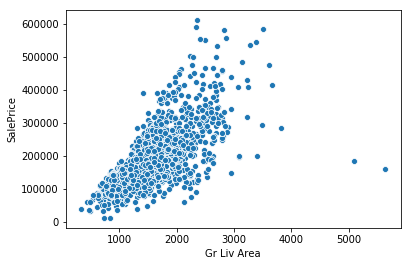

In [25]:
sns.scatterplot(x='Gr Liv Area',y='SalePrice', data=total)

From the scatterplot above, there seems to be 2 outliers where large houses are sold at unusually low prices. We will remove these 2 outliers before analysis.

In [26]:
total[(total['Gr Liv Area']>4000) & (~total['SalePrice'].isnull())]['SalePrice']

960     160000.0
1885    183850.0
Name: SalePrice, dtype: float64

In [27]:
total.iloc[[960,1885]]

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,60,RL,313.0,63887,Pave,NA,IR3,Bnk,AllPub,...,0,480,Gd,NA,NA,0,1,2008,New,160000.0
1885,2181,20,RL,128.0,39290,Pave,NA,IR1,Bnk,AllPub,...,0,0,NA,NA,Elev,17000,10,2007,New,183850.0


In [28]:
total = total.drop([960,1885], axis = 0)

In [29]:
# To check if the right number of rows have been dropped
total.shape

(2928, 80)

#### Lot Area

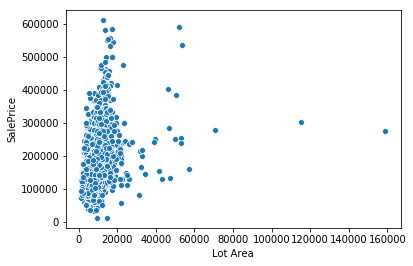

In [30]:
sns.scatterplot(x='Lot Area',y='SalePrice', data=total)

From the scatterplot of Lot Area vs SalePrice, it seemed like there are 2 outliers where the Lot Area is greater than 100000.

In [31]:
total[(total['Lot Area']>100000)]['SalePrice']

471    277000.0
694    302000.0
214         NaN
307         NaN
Name: SalePrice, dtype: float64

In [32]:
total[(total['Lot Area']>100000) & (total['SalePrice'].notna())][['Id', 'SalePrice']]

,Id,SalePrice
471,2116,277000.0
694,2072,302000.0


In [33]:
total[(total['Id']== 2116) | (total['Id']== 2072)]

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
471,2116,50,RL,63.0,159000,Pave,NA,IR2,Low,AllPub,...,0,0,NA,NA,Shed,500,6,2007,WD,277000.0
694,2072,20,RL,63.0,115149,Pave,NA,IR2,Low,AllPub,...,0,0,NA,NA,NA,0,6,2007,WD,302000.0


In [34]:
total = total[(total['Id'] != 2116) & (total['Id']!= 2072)]

In [35]:
total.shape

(2926, 80)

#### Garage Yr Blt

In [36]:
total['Garage Yr Blt'].describe()

count    2926.000000
mean     1870.628845
std       449.179835
min         0.000000
25%      1957.000000
50%      1977.000000
75%      2001.000000
max      2207.000000
Name: Garage Yr Blt, dtype: float64

In [37]:
total['Garage Yr Blt'] = total['Garage Yr Blt'].replace({2207:2007})

In [38]:
total['SalePrice'].isnull().sum()

879

In [39]:
total['SalePrice'].notna().sum()

2047

In [40]:
total.shape

(2926, 80)

### Combine Features

In [41]:
# Total Square Footage
total['TotalSF'] = total['Total Bsmt SF'] + total['Gr Liv Area']
total['TotalFloorSF'] = total['1st Flr SF'] + total['2nd Flr SF']
total['TotalPorchSF'] = total['Open Porch SF'] + total['Enclosed Porch'] + total['3Ssn Porch'] + total['Screen Porch']
    
# Total Bathrooms
total['TotalBathrooms'] = total['Full Bath'] + .5 * total['Half Bath'] + total['Bsmt Full Bath'] + .5 * total['Bsmt Half Bath']

# To add to train set to plot correlation heatmap to decide whether to keep the variables
# Total Square Footage
train['TotalSF'] = train['Total Bsmt SF'] + train['Gr Liv Area']
train['TotalFloorSF'] = train['1st Flr SF'] + train['2nd Flr SF']
train['TotalPorchSF'] = train['Open Porch SF'] + train['Enclosed Porch'] + train['3Ssn Porch'] + train['Screen Porch']
    
# Total Bathrooms
train['TotalBathrooms'] = train['Full Bath'] + .5 * train['Half Bath'] + train['Bsmt Full Bath'] + .5 * train['Bsmt Half Bath']


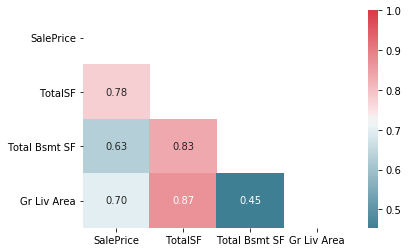

In [42]:
a = train[['SalePrice', 'TotalSF', 'Total Bsmt SF', 'Gr Liv Area']]
a = a.corr()
mask = np.zeros_like(a)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(a, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=mask)


The correlation of TotalSF is the highest with Saleprice and since Total Bsmt SF and Gr Liv Area are quite highly correlated to our new variable TotalSF, we will only keep TotalSF in the dataset.

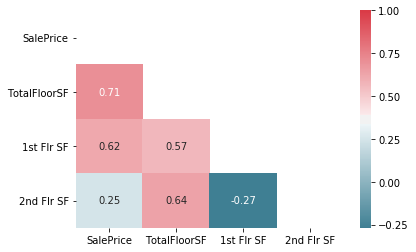

In [43]:
b = train[['SalePrice', 'TotalFloorSF', '1st Flr SF', '2nd Flr SF']]
b = b.corr()
mask = np.zeros_like(b)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(b, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=mask)


The correlation of TotalFloorSF is the highest with Saleprice and since 1st Flr SF and 2nd Flr SF are quite highly correlated to our new variable TotalFloorSF, we will only keep TotalFloorSF in the dataset.

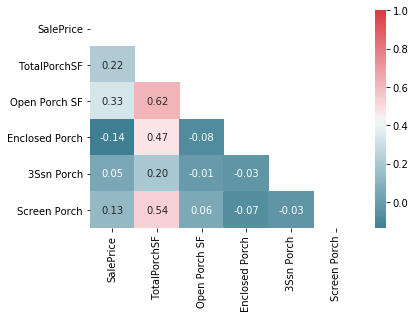

In [44]:
c = train[['SalePrice', 'TotalPorchSF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch' ]]
c = c.corr()
mask = np.zeros_like(c)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(c, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=mask)


From the correlation matrix above, it seemed like TotalPorchSF is less correlated to Saleprice as compared to Open Porch SF, I will drop TotalPorchSF.

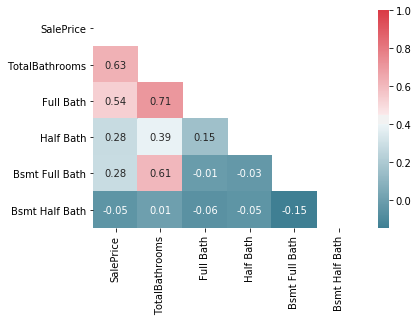

In [45]:
d = train[['SalePrice', 'TotalBathrooms', 'Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath' ]]
d = d.corr()
mask = np.zeros_like(d)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(d, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=mask)


TotalBathrooms has a greater correlation with SalePrice than the rest of the variables. Since TotalBathrooms is highly correlated with Full Bath and Bsmt Full Bath, we will only keep TotalBathrooms.

We will drop the unwanted variables from Total Dataset.

In [46]:
total = total.drop(['Total Bsmt SF', 'Gr Liv Area', '1st Flr SF', '2nd Flr SF', 'TotalPorchSF', 'Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath' ], axis = 1)

In [47]:
total.shape

(2926, 75)

In [48]:
total.head()

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,TotalSF,TotalFloorSF,TotalBathrooms
0,109,60,RL,63.0,13517,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,0,3,2010,WD,130500.0,2204.0,1479,2.5
1,544,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,0,4,2009,WD,220000.0,3035.0,2122,3.5
2,153,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,0,1,2010,WD,109000.0,2114.0,1057,2.0
3,318,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,0,4,2010,WD,174000.0,1828.0,1444,2.5
4,255,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,0,3,2010,WD,138500.0,2121.0,1445,2.0


## Exploratory Visualizations

- Look at distributions.
- Look at correlations.
- Look at relationships to target (scatter plots for continuous, box plots for categorical).


### Distributions

For exploratory visualizations of the data, we will only focus on the cleaned train datset - train_cleaned

In [49]:
train_cleaned = total[total['SalePrice'].notna()]

In [50]:
train_cleaned.shape

(2047, 75)

#### We will first look at the variable of interst - SalePrice. 

The cheapest house is sold for $ 12789.0 and the most expensive house is sold for $ 611657.0
The average sales price is $ 181373.47728383 while median is $ 162500.0


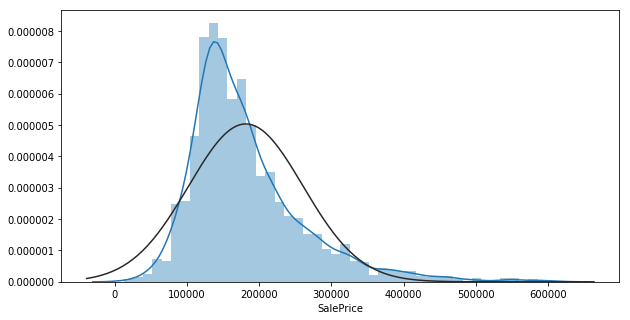

In [51]:
print('The cheapest house is sold for $ {} and the most expensive house is sold for $ {}'. format(train_cleaned['SalePrice'].min(), train_cleaned['SalePrice'].max()))
print('The average sales price is $ {} while median is $ {}'. format(train_cleaned['SalePrice'].mean(), train_cleaned['SalePrice'].median()))
fig = plt.figure(figsize= (10,5))
ax = sns.distplot(train_cleaned['SalePrice'], fit=st.norm)

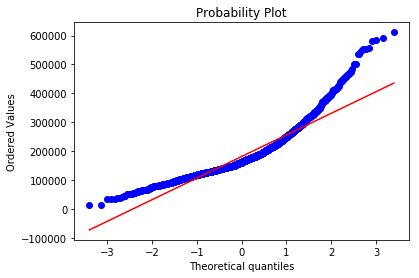

In [52]:
# draw the qq plot to check for normality
fig = plt.figure()
res = st.probplot(train_cleaned['SalePrice'], plot=plt)
plt.show()

Saleprice is positively skewed to the right, with a number of outliers. From the probability plot, we can also see that saleprice does not follow the normal distribution(the red diagonal line) well, we will transform sale price to log normal to see if it fits the distribution better before running our model.

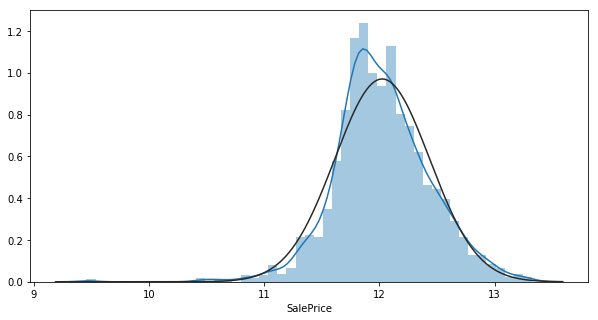

In [53]:
fig = plt.figure(figsize= (10,5))
sns.distplot(np.log(train_cleaned['SalePrice']), fit=st.norm)

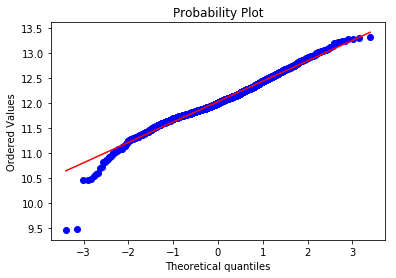

In [54]:
# draw the qq plot to check for normality
fig = plt.figure()
res = st.probplot(np.log(train_cleaned['SalePrice']), plot=plt)
plt.show()

The sale price data follows the log normal distribution better, we can see that the data follows the diagonal line better. So, we will log transform sale price later before running our model.

#### Followed by distribution plots of numerical features

There are 31 numerical features


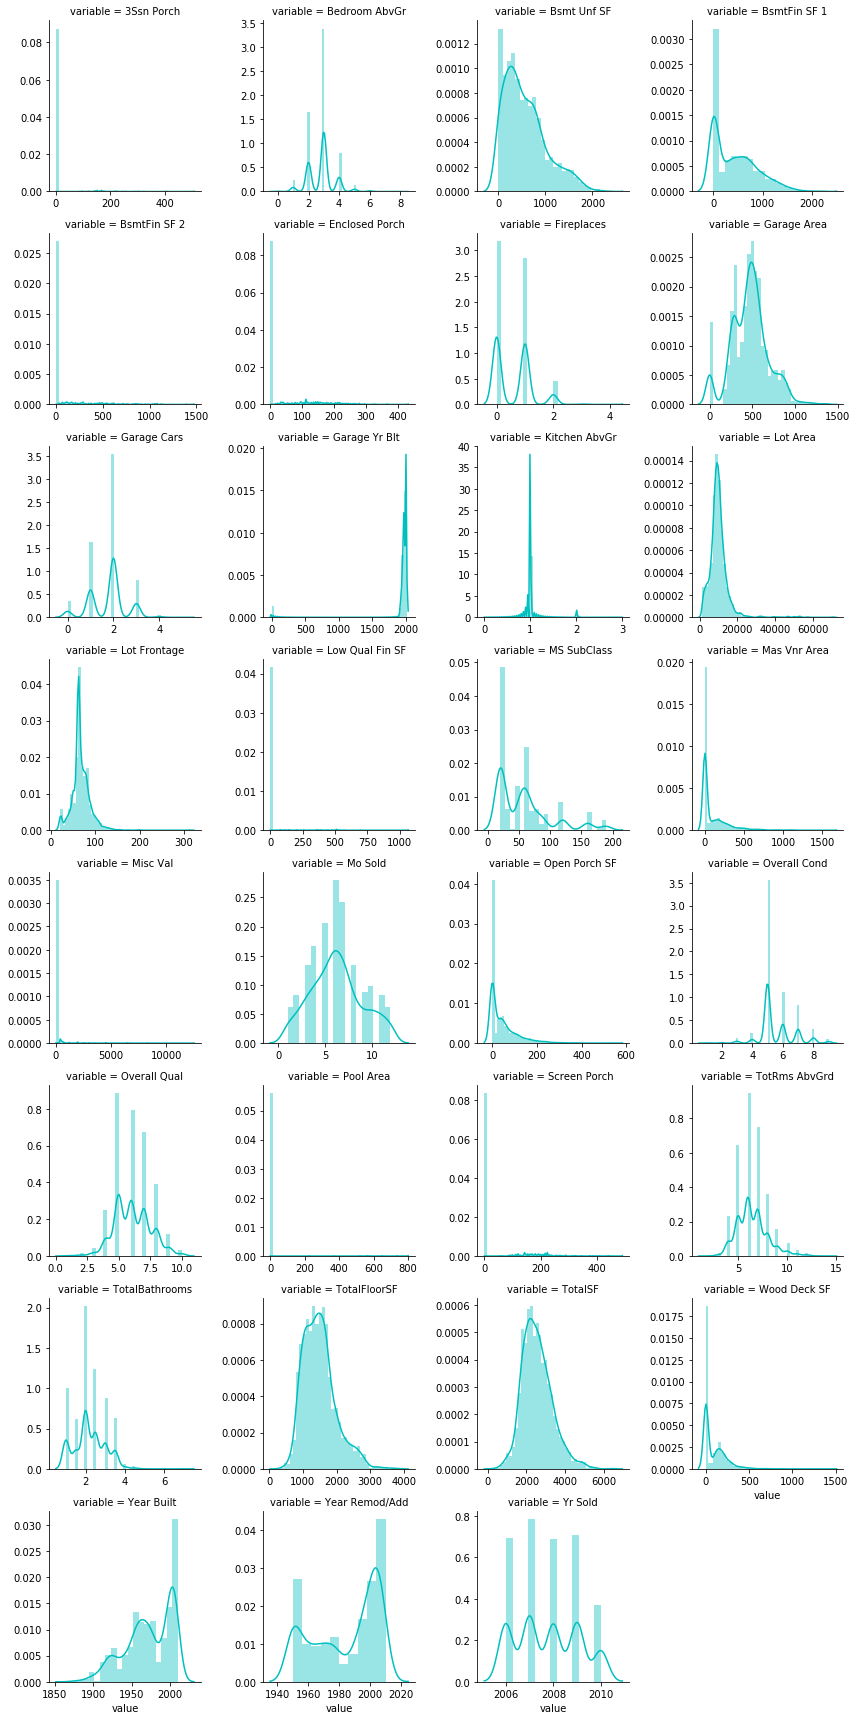

In [55]:
numeric = [i for i in train_cleaned.select_dtypes(include=[np.number]).columns]
numeric.remove('Id')
numeric.remove('SalePrice')
print('There are {} numerical features'.format(len(numeric)))
               
f = pd.melt(train_cleaned, value_vars=sorted(numeric))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value', color='c')

A few variables are also positively skewed, similar to SalePrice. 


Also, there are 3 variables that I think should be categorical instead of numeric - MS SubClass, MO Sold and Yr Sold. 

In [56]:
# To transform MS SubClass, MO Sold and Yr Sold into categorical variables.
train_cleaned.loc[:,'MS SubClass'] = train_cleaned['MS SubClass'].astype('object')
train_cleaned.loc[:,'Mo Sold'] = train_cleaned['Mo Sold'].astype('object')
train_cleaned.loc[:,'Yr Sold'] = train_cleaned['Yr Sold'].astype('object')

/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [57]:
numeric = [i for i in train_cleaned.select_dtypes(include=[np.number]).columns]
numeric.remove('Id')
numeric.remove('SalePrice')
len(numeric)

28

In [58]:
category = [i for i in train_cleaned.select_dtypes(include='object').columns]
len(category)

45

#### The categorical features

There are 45 catgorical variables


/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


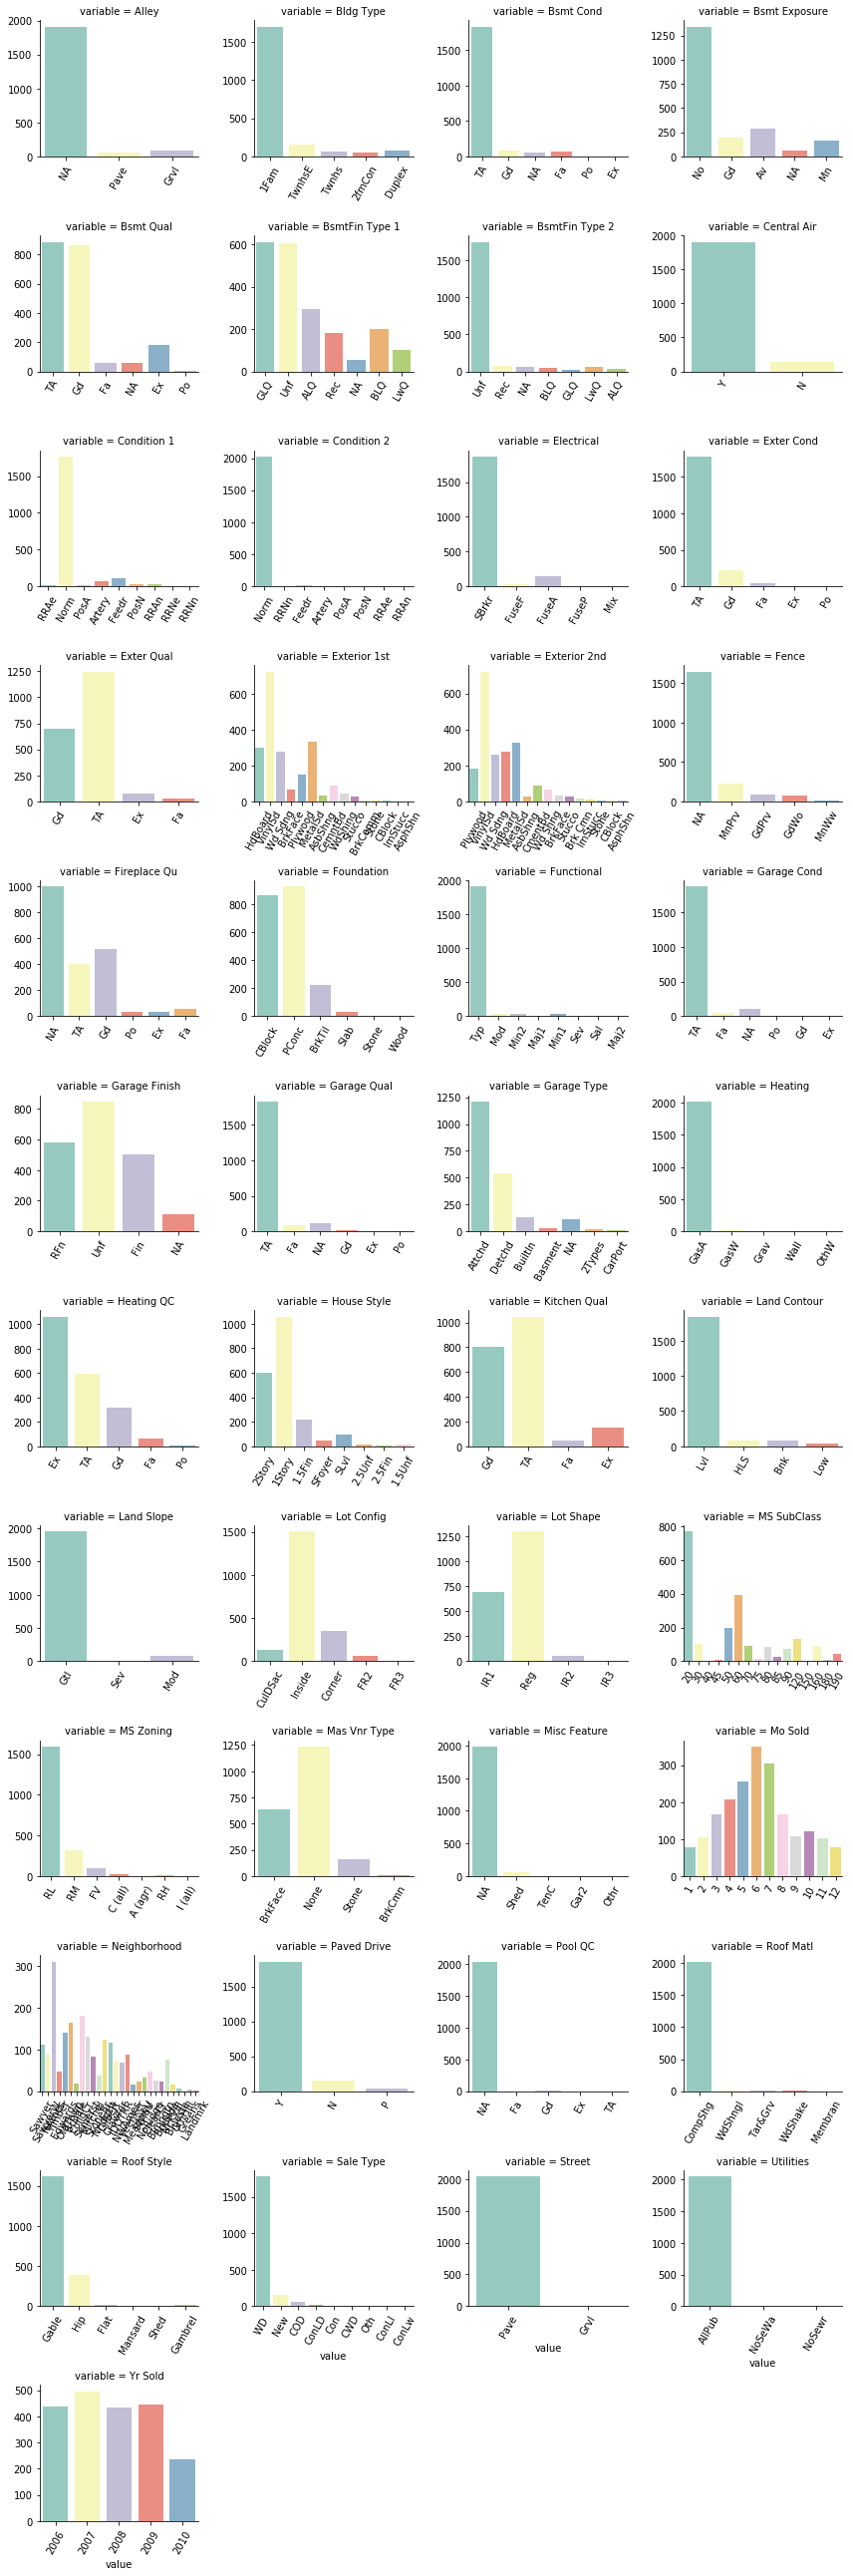

In [59]:
category = [i for i in train_cleaned.select_dtypes(include='object').columns]
print('There are {} catgorical variables'.format(len(category)))

f = pd.melt(train_cleaned, value_vars=sorted(category))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value', palette='Set3')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

### Correlations

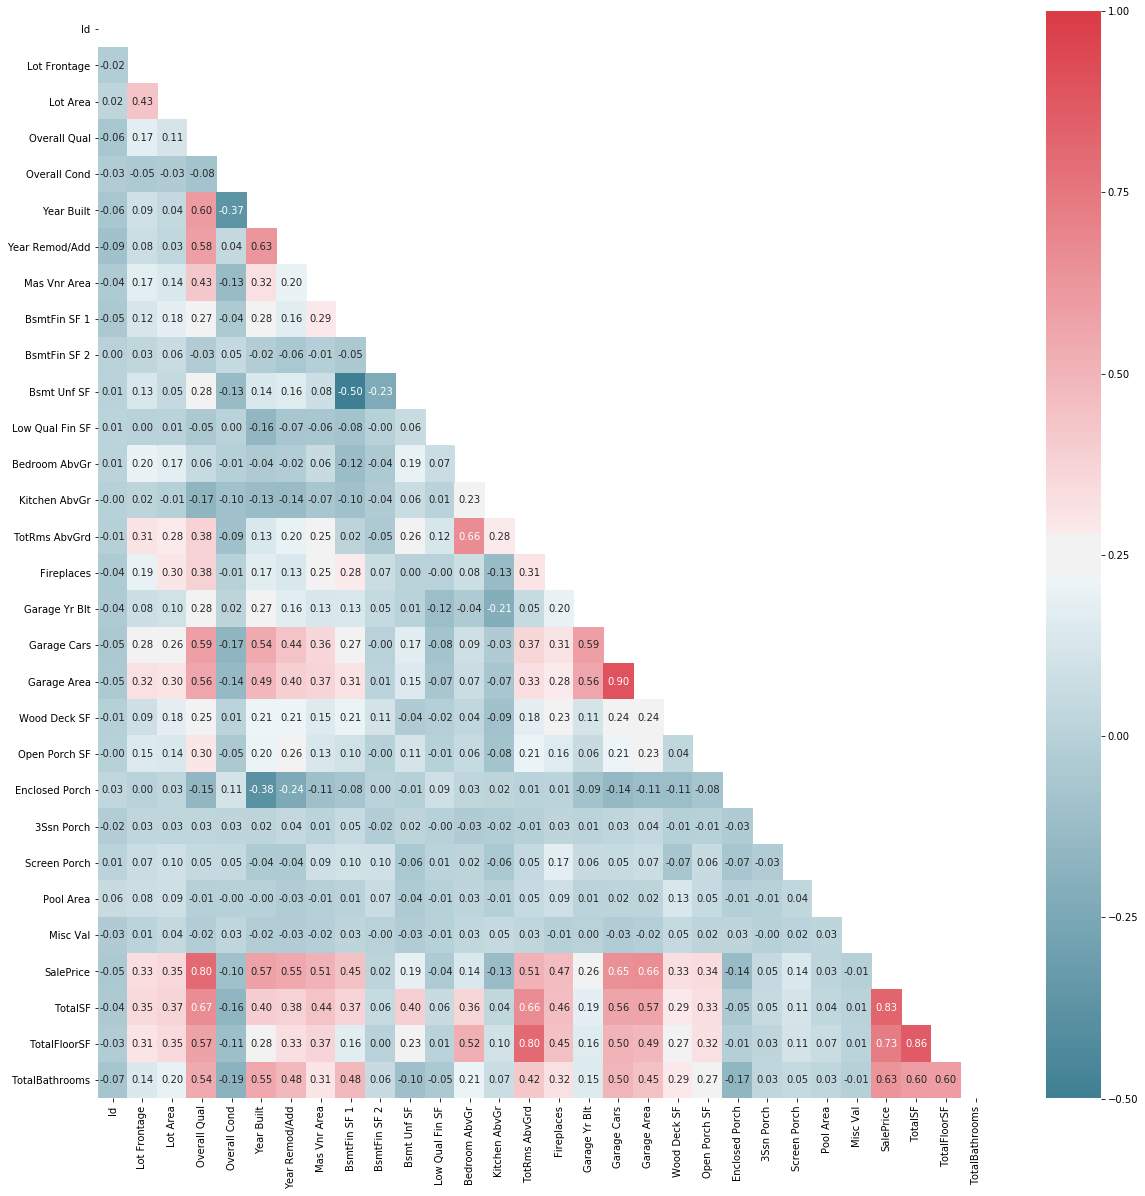

In [60]:
corr = train_cleaned.corr()
plt.figure(figsize=(20, 20))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=mask)
#sns.set(font_scale=0.8)
plt.show()

To include variables in our model, the features must be correlated to our dependent variable which is SalePrice in this case. But we should also take note not to add in indepedent variables that are correlated to each other. 

In the correlation heatmap, we can see that TotalSF (0.83) has the highest correlation with our target variable (SalePrice) followed by Overall quality(0.8). This finding is pretty intuitive as we would expect the overall quality and total size to have the greatest impact on the price of the house. 

From the heatmap above, we also realized that there might be an issue of collinearity. For example:

1. The correlation between the Garage Area(size of garage in square feet) and Garage Cars (size of garage in car capacity) is very high (0.9) and they're both correlated to SalePrice.
2. The total floor square feet (TotalFloorSF) and total square feet (TotSF) is also highly correlated - 0.86.
3. The total floor square feet (TotalFloorSF) and total rooms above ground (TotRmsAbvGrd) is also highly correlated - 0.8.

### Relationships to SalePrice 

We will plot scatterplots for numeric variables and box plots for categorical variables.

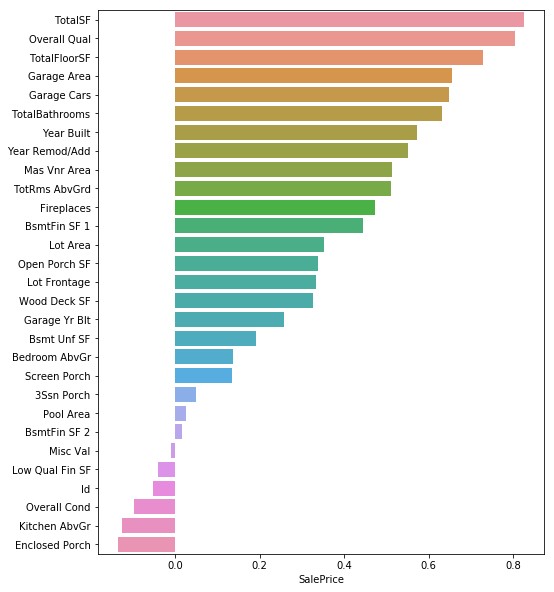

In [61]:
# We will arrange the features in descending order based on their correlation with SalePrice
corr = corr.sort_values('SalePrice', ascending=False)
plt.figure(figsize=(8,10))
sns.barplot( corr.SalePrice[1:], corr.index[1:], orient='h')
plt.show()

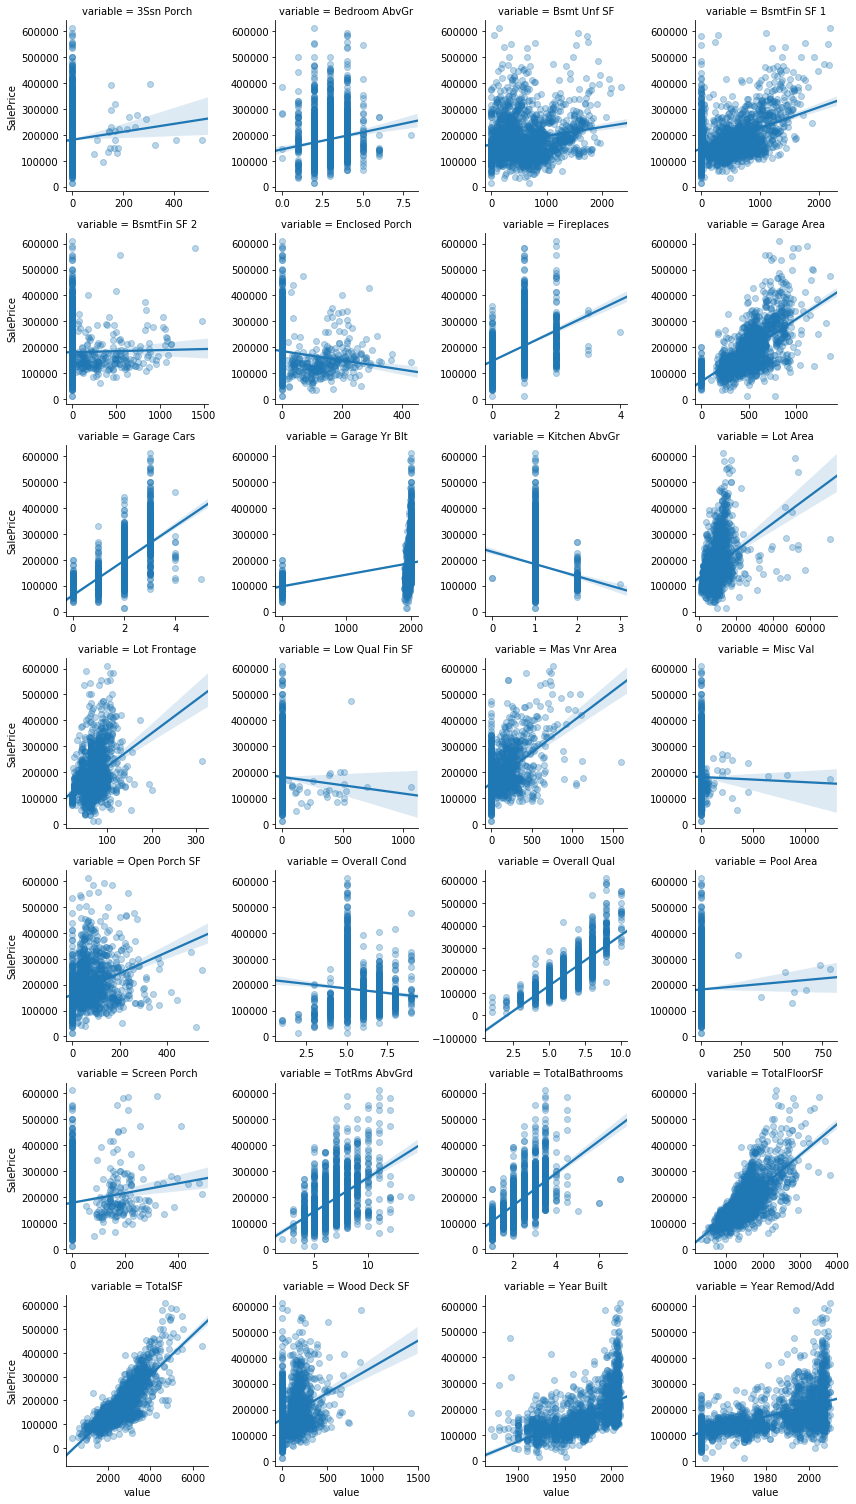

In [62]:
# Scatter plots of numerical features against SalePrice
f = pd.melt(train_cleaned, id_vars=['SalePrice'], value_vars=sorted(numeric))
f['value'] = f['value'].astype('float')
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.regplot, 'value', 'SalePrice',scatter_kws={'alpha':0.3})


# [plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
# g.fig.tight_layout()
# plt.show()

There are a few features which are strongly correlated with SalePrice - OverallQual, TotalSF, and TotRmsAbvGrd. This makes sense as we would expect the overall quality, total size and total number of rooms to contribute the most to the sale prices of the house.

/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


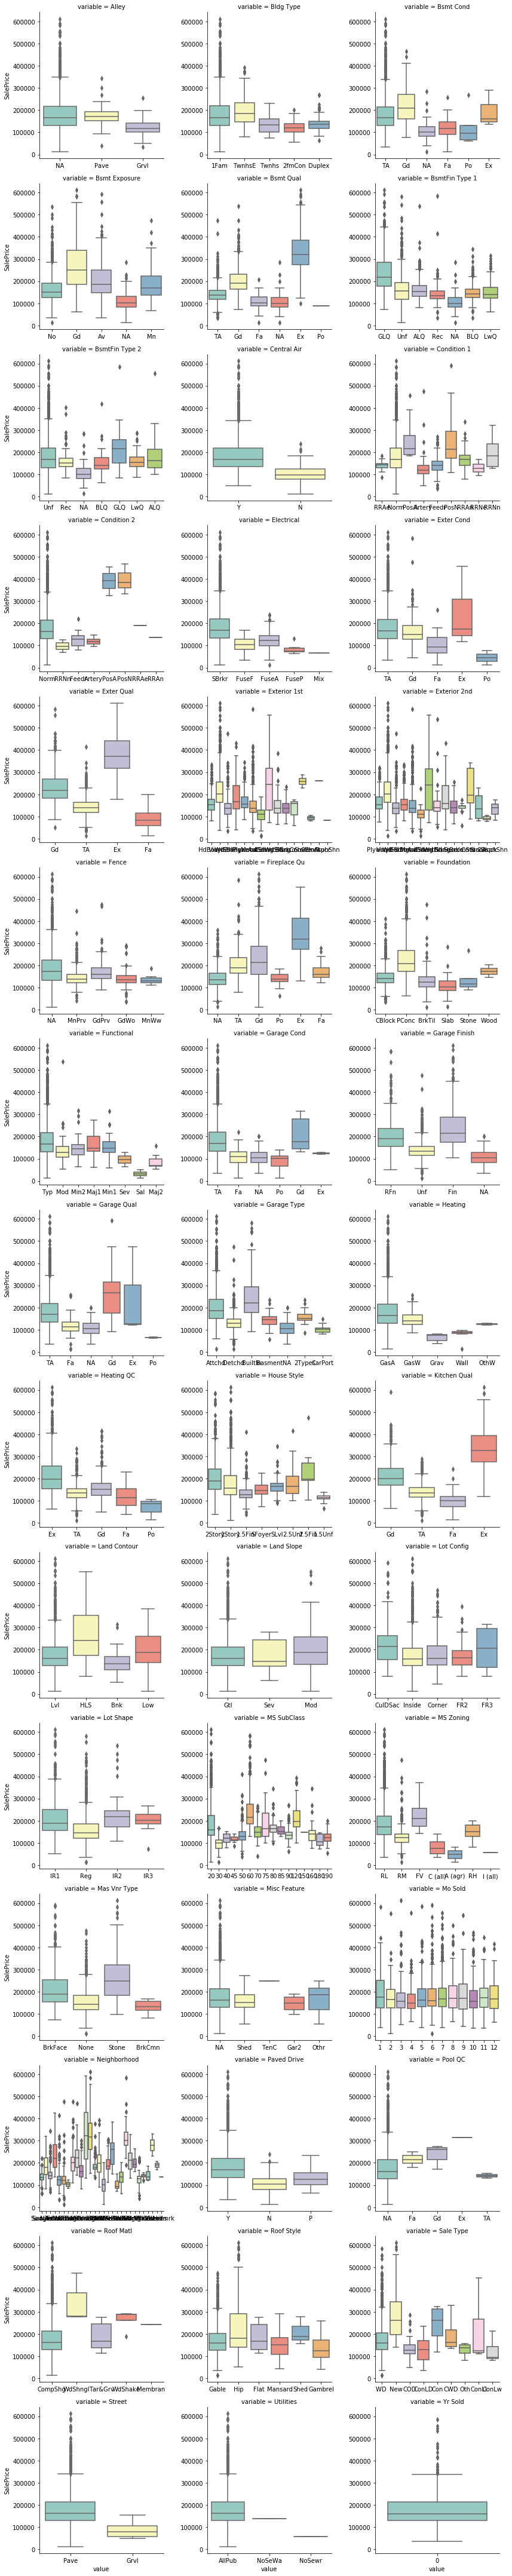

In [63]:
# Boxplots for categorical variables against SalePrice
f = pd.melt(train_cleaned, id_vars=['SalePrice'], value_vars=sorted(category)) #to reshape data
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
g = g.map(sns.boxplot, 'value', 'SalePrice', palette='Set3')
sns.boxplot()

The boxplots show that some of the variables like Neighbourhood and MSSub Class have greater variance.

## Pre-Processing

- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.


### One-hot encode categorical variables

In [64]:
total = pd.get_dummies(total)
total.shape

(2926, 307)

### Train/test split the data 

In [65]:
train_cleaned.shape

(2047, 75)

In [66]:
# To logtransform saleprice
#train_cleaned_encode.loc[:, 'SalePrice'] = np.log(train['SalePrice'])

In [67]:
train_cleaned_encode = total[total['SalePrice'].notna()]
train_cleaned_encode.shape

(2047, 307)

In [68]:
test_cleaned_encode = total[total['SalePrice'].isnull()]
test_cleaned_encode = test_cleaned_encode.drop(['SalePrice','Id'],axis =1)
test_cleaned_encode.shape

(879, 305)

In [69]:
X = train_cleaned_encode.drop(['SalePrice','Id'],axis =1)
y = np.log(train_cleaned_encode['SalePrice'])
print(X.shape)
y.shape

(2047, 305)


(2047,)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=(42))

### Scaling the data

In [71]:
len(numeric)

28

In [72]:
# To only scale the numeric data

scaler = StandardScaler()
X_train.loc[:,numeric] = scaler.fit_transform(X_train[numeric])
X_test.loc[:,numeric] = scaler.transform(X_test[numeric])
print(X_train.shape)
print(X_test.shape)

/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input d

(1637, 305)
(410, 305)


In [73]:
# To scale numeric data
test_cleaned_encode.loc[:,numeric] = scaler.transform(test_cleaned_encode[numeric])
test_cleaned_encode.shape

/Users/suying/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


(879, 305)

## Modeling

- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.


### Baseline Score

In [74]:
print(y_test.shape)
baseline_y_pred = pd.DataFrame(y_test)
baseline_y_pred = np.exp(baseline_y_pred)
baseline_y_pred['Saleprice_mean'] = baseline_y_pred['SalePrice'].mean()
baseline_y_pred.head()

(410,)


,SalePrice,Saleprice_mean
1478,142500.0,174608.068293
693,235128.0,174608.068293
100,387000.0,174608.068293
1829,245700.0,174608.068293
1764,290000.0,174608.068293


In [75]:
rms_baseline = np.sqrt(mean_squared_error(baseline_y_pred['SalePrice'], baseline_y_pred['Saleprice_mean']))
rms_baseline

76750.87980724114

### Regression Modelling

In [76]:
lr = LinearRegression().fit(X_train,y_train)

In [77]:
cv_scores = cross_val_score(lr, X_train, y_train, cv = 5)
print('The cv scores of all the 5 folds is {}'.format(cv_scores))
print('The average 5-fold CV score is {}'.format(cv_scores.mean()))


The cv scores of all the 5 folds is [0.87682175 0.88355269 0.85993086 0.89905095 0.90910398]
The average 5-fold CV score is 0.8856920433295803


In [78]:
# Predicting on test set
y_pred = lr.predict(X_test)

# Evaluating performance measure on the training set - R2 and RMS
print('R2: {}'.format(lr.score(X_test,y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))


R2: 0.8747151543576854
Root Mean Squared Error: 19891.254231808154


In [79]:
# # Creating histogram of residual
# sns.distplot(y_train - y_pred)
# plt.title('Distribution of Residuals')

The regression model scores across the cross validations varies quite a bit, this may imply that model is not robust and there may be overfitting. We will try Lasso Regression next to feature select.

### Lasso

In [80]:
l_alphas = np.arange(0.001, 0.15, 0.0025)
lasso_model = LassoCV(alphas=l_alphas, cv=5 )
lasso_model = lasso_model.fit(X_train,y_train)
alpha_l = lasso_model.alpha_
alpha_l

0.001

In [81]:
lasso_model = Lasso(alpha=alpha_l)
lasso_model = lasso_model.fit(X_train,y_train)
lasso_cv_mean_mse = -cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lasso_cv_mean_r2 = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='r2').mean()
lasso_cv_r2 = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='r2')

print('The mean square error is {}'.format(lasso_cv_mean_mse))
print('The mean R2 is {}'.format(lasso_cv_mean_r2))
print('The R2 from the 5 fold is {}'.format(lasso_cv_r2))

The mean square error is 0.014631999305304188
The mean R2 is 0.9140803272081733
The R2 from the 5 fold is [0.91255548 0.91299002 0.89880895 0.91982033 0.92622685]


In [82]:
coef = pd.DataFrame({'LassoCoefficient': lasso_model.coef_, 'is_positive': lasso_model.coef_ > 0, 'abs_coef': np.abs(lasso_model.coef_) })
col = X_train.columns.tolist()
coef.set_index([col], inplace=True)
#coef.columns = ['LassoCoefficient']
print('{} coefficients are kept out of {} coefficients'.format(sum(coef['LassoCoefficient'] != 0), len(coef)))

78 coefficients are kept out of 305 coefficients


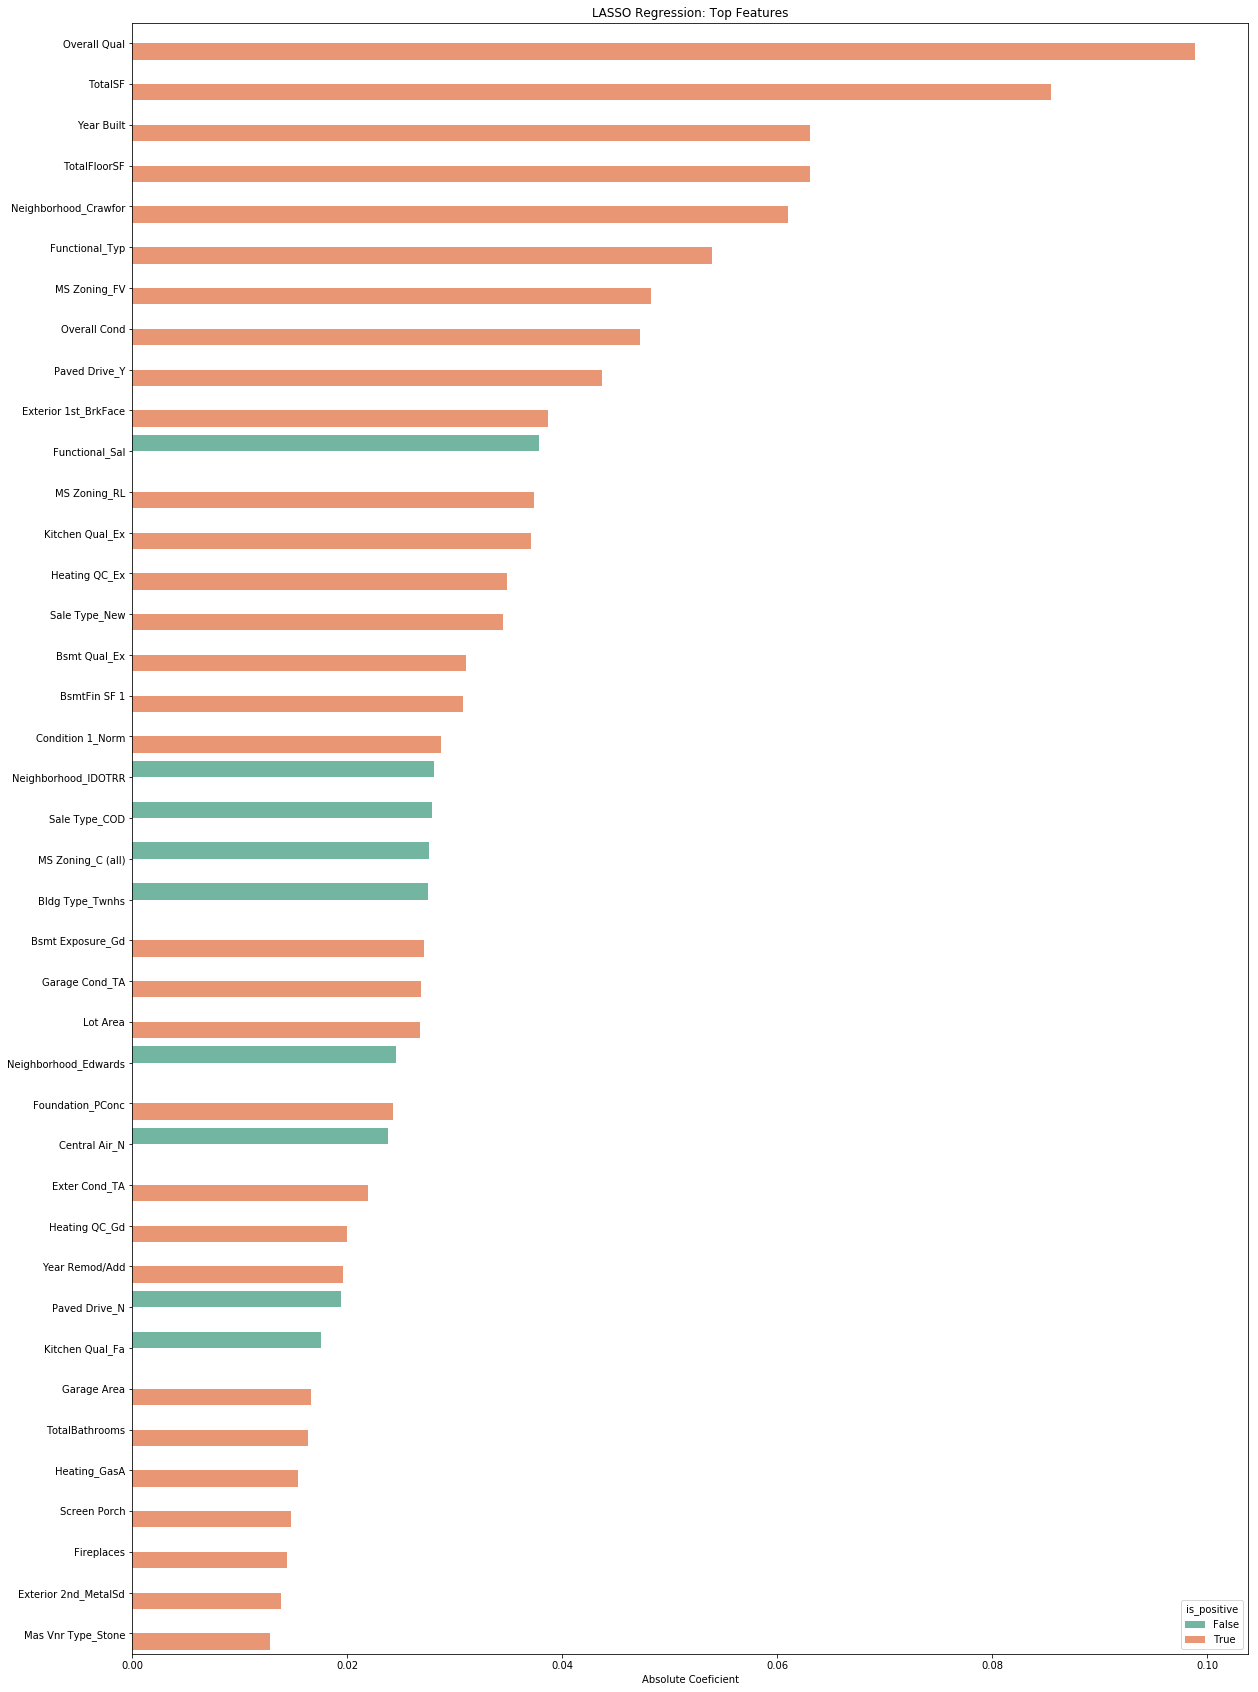

In [83]:
top_coefs = coef.sort_values('abs_coef', ascending=False).head(40)
plt.figure(figsize=(20,30))
sns.barplot(top_coefs['abs_coef'], top_coefs.index, orient='h', hue=top_coefs['is_positive'], palette='Set2')
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

In [84]:
top_coefs.head()

,LassoCoefficient,is_positive,abs_coef
Overall Qual,0.098871,True,0.098871
TotalSF,0.085495,True,0.085495
Year Built,0.063092,True,0.063092
TotalFloorSF,0.063065,True,0.063065
Neighborhood_Crawfor,0.061006,True,0.061006


In [85]:
X_test.shape

(410, 305)

In [86]:
# Predicting on training set
y_pred_train = lasso_model.predict(X_train)

# Predicting on test set
y_pred = lasso_model.predict(X_test)

# Evaluating performance measure on the test set - R2 and RMS
print('R2: {}'.format(lasso_model.score(X_test,y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))


R2: 0.889376894101733
Root Mean Squared Error: 18269.578444744042


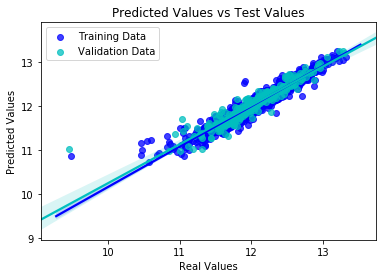

In [87]:
# Scatterplot of Predictions Vs. Actual Values
sns.regplot(y = y_pred_train, x = y_train, color = 'blue', label = 'Training Data', scatter_kws={'alpha':0.75})
sns.regplot(y = y_pred, x = y_test, color = 'c', label = 'Validation Data', scatter_kws={'alpha':0.75})
plt.title('Predicted Values vs Test Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')

Text(0.5, 0, 'Predicted Values')

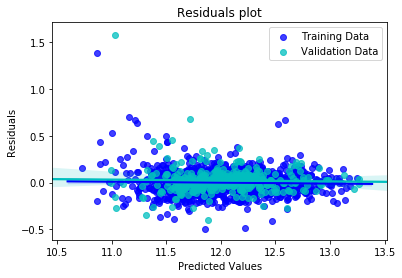

In [88]:
# Plotting Residuals
sns.regplot(x = y_pred_train, y = y_pred_train - y_train, label = 'Training Data', color = 'blue', scatter_kws={'alpha':0.75})
sns.regplot(x = y_pred, y = y_pred - y_test, label = 'Validation Data', color = 'c', scatter_kws={'alpha':0.75})
plt.legend(loc = 'best')
plt.title('Residuals plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')

Codes below are for kaggle submission

In [89]:
# test_cleaned_encode = test_cleaned_encode.drop(['SalePrice', 'Id'], axis = 1)
# y_pred_test = lasso_model.predict(test_cleaned_encode)


In [90]:
# y_pred_test = np.exp(y_pred_test)
# y_pred_test.shape

In [91]:
# y_pred_test.mean()

In [92]:
# y_pred_test = pd.DataFrame(y_pred_test)

In [93]:
# final_kaggle = y_pred_test.join(test["Id"], how='outer')
# final_kaggle = final_kaggle[['Id', 0]]
# final_kaggle.columns = ['Id','SalePrice']
# print(final_kaggle)
# final_kaggle.to_csv('sy_final_kaggle.csv',index=False)

In [94]:
# final_kaggle.shape

### More feature selections and then run Ridge Regression

Running Lasso Regression helped to feature select a little, I will keep the features that Lasso kept and further run a Ridge regression on the remaining 78 features.

I will removed all the columns where it's lasso coefficient is equals to 0 in X_train, X_test and test_cleaned_encode. This is to ensure that all 3 datasets will have the same number of columns.

In [95]:
# Features which i will be dropping
coef[coef.LassoCoefficient==0]

,LassoCoefficient,is_positive,abs_coef
Bsmt Unf SF,-0.0,False,0.0
Garage Yr Blt,0.0,False,0.0
Misc Val,0.0,False,0.0
MS Zoning_A (agr),-0.0,False,0.0
MS Zoning_I (all),-0.0,False,0.0
MS Zoning_RH,0.0,False,0.0
MS Zoning_RM,-0.0,False,0.0
Street_Grvl,-0.0,False,0.0
Street_Pave,0.0,False,0.0
Alley_Grvl,0.0,False,0.0


In [96]:
test_cleaned_encode.shape

(879, 305)

In [97]:
# Get list of variables that lasso coeff = 0 
coef_new = coef[coef['LassoCoefficient']==0]

# To drop these columns where lasso coeff = 0 
drop = coef_new.index.tolist()
X_train1 = X_train.drop(drop, axis = 1)
X_test1 = X_test.drop(drop, axis = 1)
test_cleaned_encode1 = test_cleaned_encode.drop(drop, axis = 1)
print(X_train1.shape)
print(X_test1.shape)
print(test_cleaned_encode1.shape)

(1637, 78)
(410, 78)
(879, 78)


In [98]:
r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=r_alphas, cv=5 )
ridge_model = ridge_model.fit(X_train1,y_train)
alpha_r = ridge_model.alpha_
print('The optimal alpha for the ridge model is {}'.format(alpha_r))

ridge_model = Ridge(alpha=alpha_r)
ridge_model = ridge_model.fit(X_train1,y_train)
ridge_cv_mean_mse = -cross_val_score(ridge_model, X_train1, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cv_mean_r2 = cross_val_score(ridge_model, X_train1, y_train, cv=5, scoring='r2').mean()
ridge_cv_r2 = cross_val_score(ridge_model, X_train1, y_train, cv=5, scoring='r2')
print('The mean square error is {}'.format(ridge_cv_mean_mse))
print('The mean R2 is {}'.format(ridge_cv_mean_r2))
print('The R2 from the 5 fold is {}'.format(ridge_cv_r2))      
      

# To create a dataframe on details of ridge coeff
coef_r = pd.DataFrame({'RidgeCoefficient': ridge_model.coef_, 'is_positive': ridge_model.coef_ > 0, 'abs_coef': np.abs(ridge_model.coef_) })
col = X_train1.columns.tolist()
coef_r.set_index([col], inplace=True)

The optimal alpha for the ridge model is 12.750512407130135
The mean square error is 0.013562873332914416
The mean R2 is 0.9201237901215895
The R2 from the 5 fold is [0.91815508 0.91793773 0.91089331 0.92080532 0.93282751]


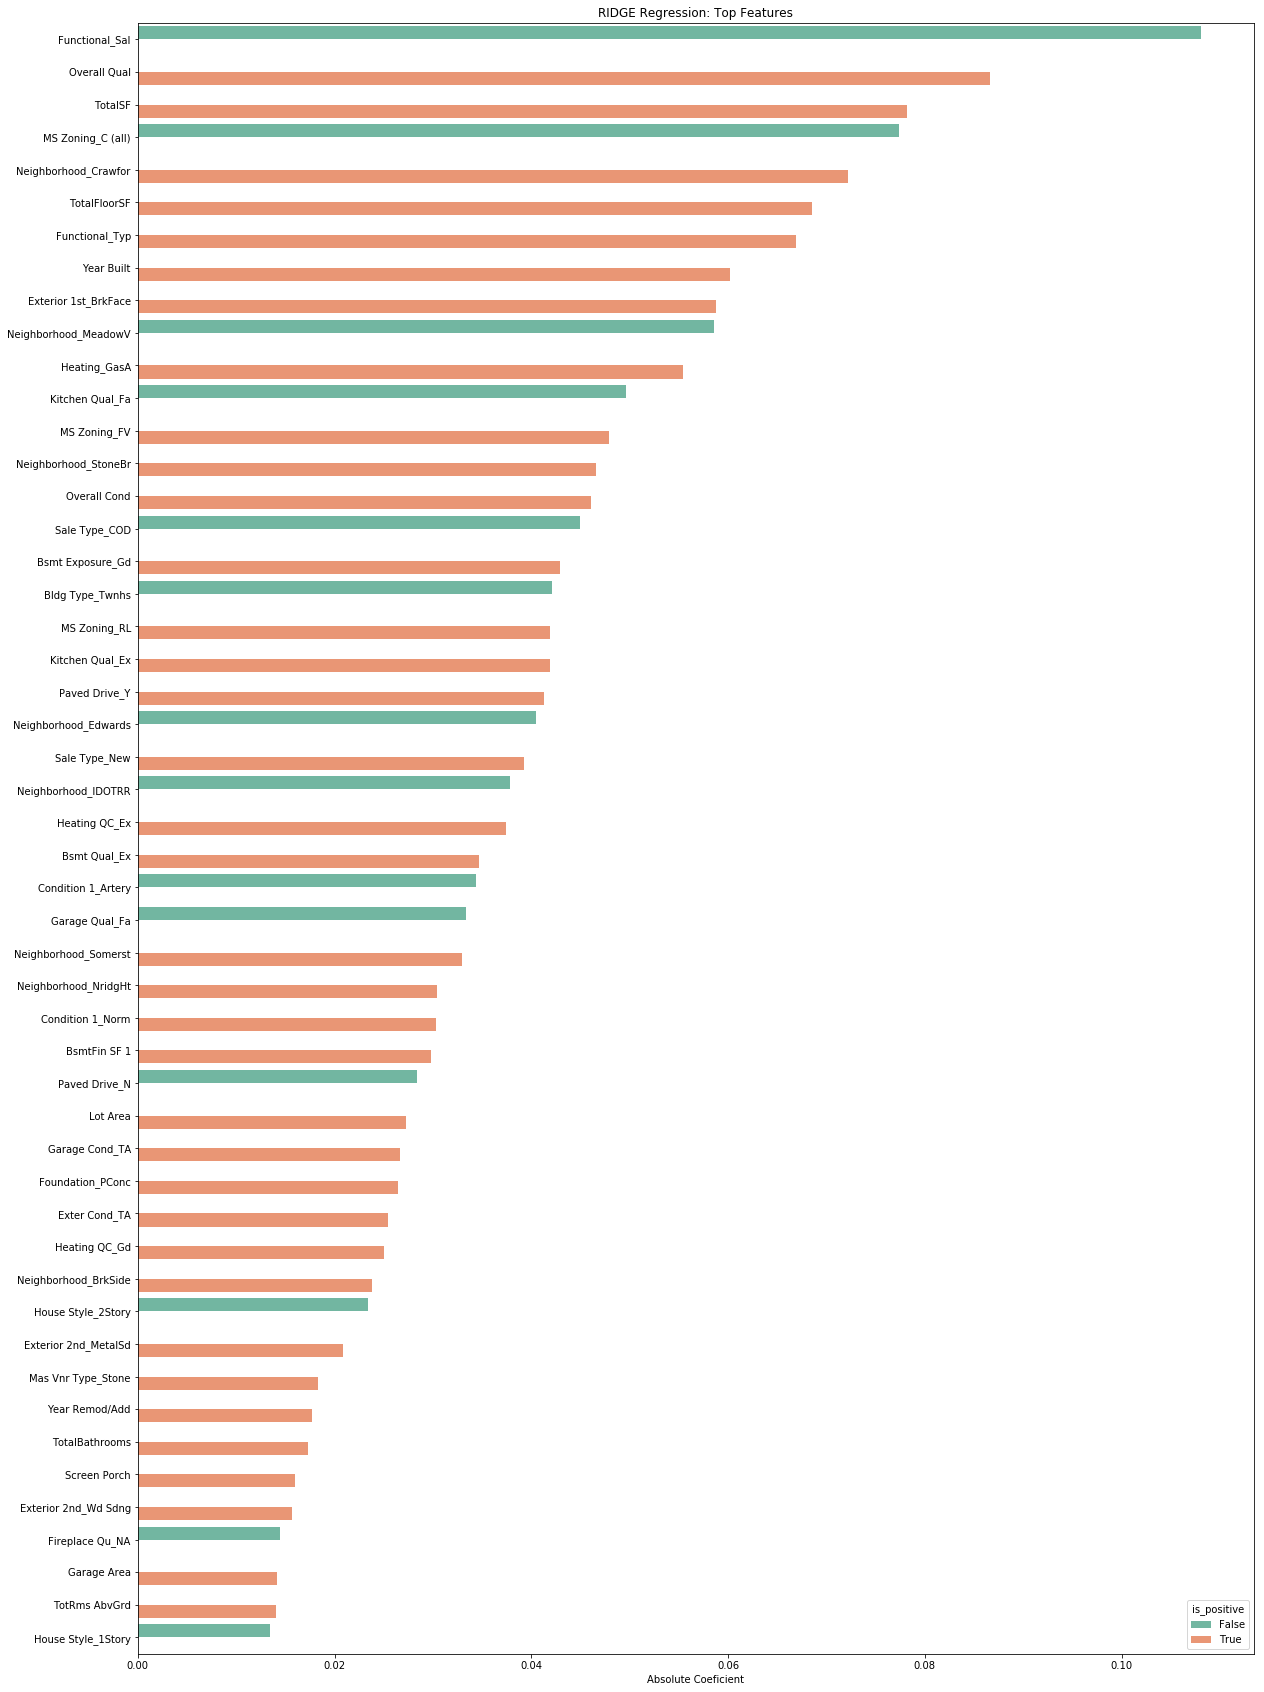

In [99]:
# Take a closer look at the top 40 features with highest correlation with saleprice
top_coefs1 = coef_r.sort_values('abs_coef', ascending=False).head(50)
plt.figure(figsize=(20,30))
sns.barplot(top_coefs1['abs_coef'], top_coefs1.index, orient='h', hue=top_coefs1['is_positive'], palette='Set2')
plt.title('RIDGE Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

In [100]:
# Predicting on training set
y_pred_train = ridge_model.predict(X_train1)

# Predicting on test set
y_pred = ridge_model.predict(X_test1)

# Evaluating performance measure on the test set - R2 and RMS
print('R2: {}'.format(ridge_model.score(X_test1,y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))


R2: 0.8909332291921814
Root Mean Squared Error: 18272.423465554326


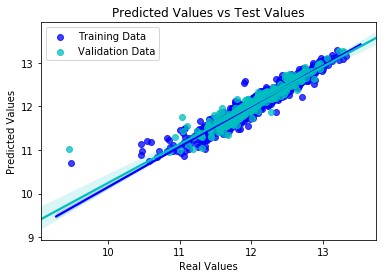

In [101]:
# Scatterplot of Predictions Vs. Actual Values
sns.regplot(y = y_pred_train, x = y_train, color = 'blue', label = 'Training Data', scatter_kws={'alpha':0.75})
sns.regplot(y = y_pred, x = y_test, color = 'c', label = 'Validation Data', scatter_kws={'alpha':0.75})
plt.title('Predicted Values vs Test Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')

Text(0.5, 0, 'Predicted Values')

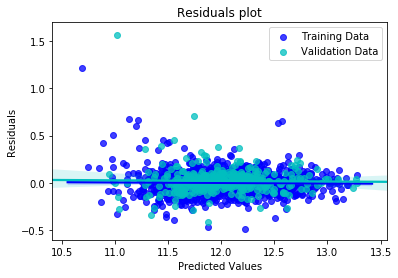

In [102]:
# Plotting Residuals
sns.regplot(x = y_pred_train, y = y_pred_train - y_train, label = 'Training Data', color = 'blue', scatter_kws={'alpha':0.75})
sns.regplot(x = y_pred, y = y_pred - y_test, label = 'Validation Data', color = 'c', scatter_kws={'alpha':0.75})
plt.legend(loc = 'best')
plt.title('Residuals plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')

Codes below are for kaggle submission

In [103]:
# y_predr = ridge_model.predict(X_test)
# y_predr.shape

In [104]:
# lr_rms = np.sqrt(mean_squared_error(np.exp(y_test),np.exp(y_predr)))
# lr_rms

In [105]:
# y_pred_testr = ridge_model.predict(test_cleaned_encode)
# y_pred_testr = np.exp(y_pred_testr)
# y_pred_testr.shape

In [106]:
# y_pred_testr.mean()

In [107]:
# y_pred_testr = pd.DataFrame(y_pred_testr)
# final_kaggle = y_pred_testr.join(test["Id"], how='outer')
# final_kaggle = final_kaggle[['Id', 0]]
# final_kaggle.columns = ['Id','SalePrice']
# print(final_kaggle)
# final_kaggle.to_csv('sy_final_kaggle1.csv',index=False)

### Based on ridge top 40 coefficients, we will choose top 15 features to keep.

As TotalSF and TotalFloorSF are strongly correlated, we will just include TotalSF in the model since it has a larger coefficient. It was also quite surprising to find that houses in commercial area has a negative relationship with sale prices, hence we would not be keeping MS Zoning_C in the model.

In [108]:
coef_to_keep = ['Functional_Sal', 'Overall Qual', 'TotalSF', 'Neighborhood_Crawfor', 'Functional_Typ', 'Year Built', 'Exterior 1st_BrkFace', 'Neighborhood_MeadowV', 'Heating_GasA', 'Kitchen Qual_Fa', 'MS Zoning_FV', 'Neighborhood_StoneBr', 'Overall Cond', 'Bsmt Exposure_Gd', 'Bldg Type_Twnhs' ]


In [109]:
X_train2 = X_train[coef_to_keep]
X_test2 = X_test[coef_to_keep]
test_cleaned_encode2 = test_cleaned_encode[coef_to_keep]
print(X_train2.shape)
print(X_test2.shape)
print(test_cleaned_encode2.shape)

(1637, 15)
(410, 15)
(879, 15)


In [110]:
r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=r_alphas, cv=5 )
ridge_model = ridge_model.fit(X_train2,y_train)
alpha_r = ridge_model.alpha_
print('The optimal alpha for the ridge model is {}'.format(alpha_r))

ridge_model = Ridge(alpha=alpha_r)
ridge_model = ridge_model.fit(X_train2,y_train)
ridge_cv_mean_mse = -cross_val_score(ridge_model, X_train2, y_train, cv=5, scoring='neg_mean_squared_error').mean()
ridge_cv_mean_r2 = cross_val_score(ridge_model, X_train2, y_train, cv=5, scoring='r2').mean()
ridge_cv_r2 = cross_val_score(ridge_model, X_train2, y_train, cv=5, scoring='r2')
print('The mean square error is {}'.format(ridge_cv_mean_mse))
print('The mean R2 is {}'.format(ridge_cv_mean_r2))
print('The R2 from the 5 fold is {}'.format(ridge_cv_r2))      

coef_r2 = pd.DataFrame({'RidgeCoefficient': ridge_model.coef_, 'is_positive': ridge_model.coef_ > 0, 'abs_coef': np.abs(ridge_model.coef_) })
col2 = X_train2.columns.tolist()
coef_r2.set_index([col2], inplace=True)


The optimal alpha for the ridge model is 1.0
The mean square error is 0.02088574851302779
The mean R2 is 0.8774068063032452
The R2 from the 5 fold is [0.87990259 0.86609292 0.87396481 0.88425147 0.88282226]


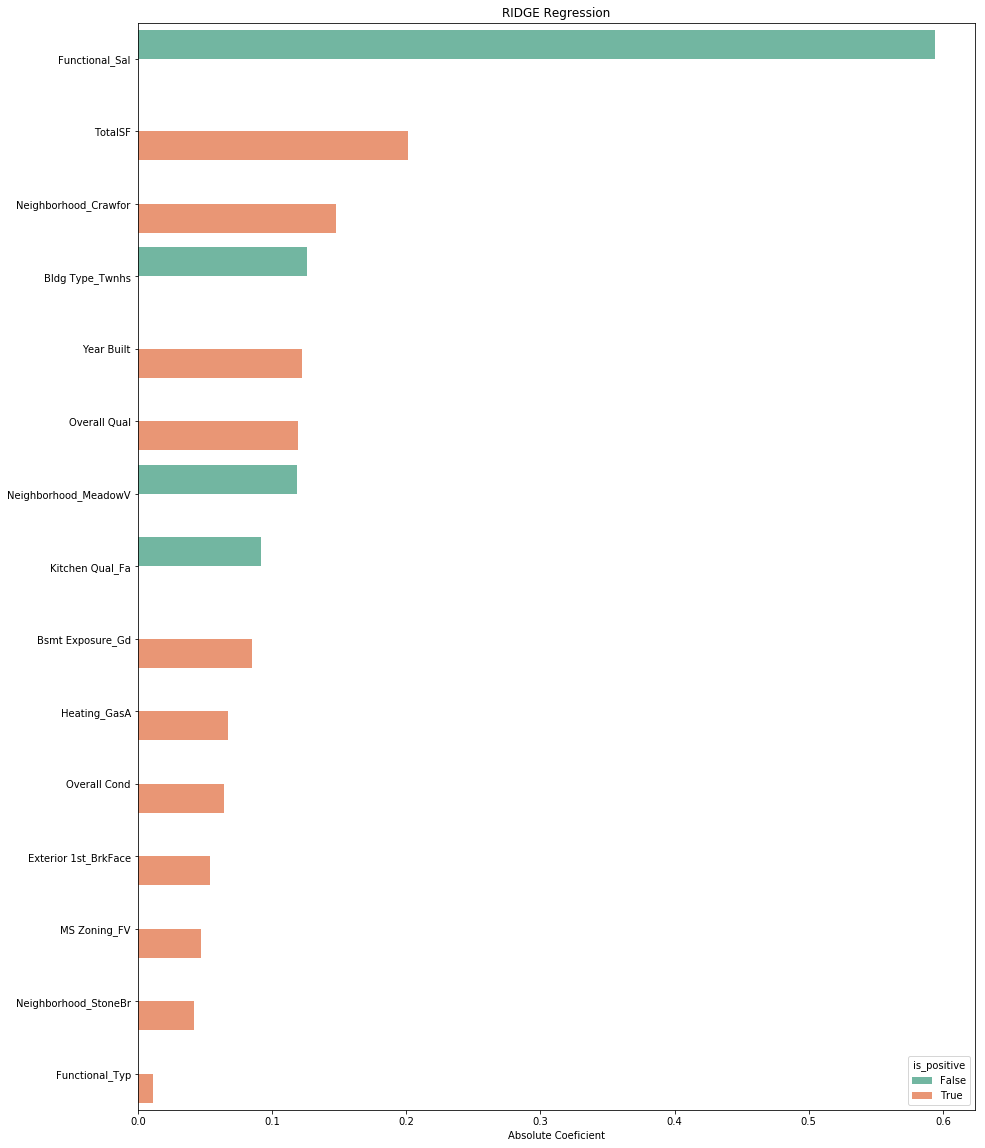

In [111]:
# Take a closer look at the top features with highest correlation with saleprice
top_coefs2 = coef_r2.sort_values('abs_coef', ascending=False)
plt.figure(figsize=(15,20))
sns.barplot(top_coefs2['abs_coef'], top_coefs2.index, orient='h', hue=top_coefs2['is_positive'], palette='Set2')
plt.title('RIDGE Regression')
plt.xlabel('Absolute Coeficient')
plt.show()

In [112]:
# Predicting on training set
y_pred_train = ridge_model.predict(X_train2)

# Predicting on test set
y_pred = ridge_model.predict(X_test2)

# Evaluating performance measure on the test set - R2 and RMS
print('R2: {}'.format(ridge_model.score(X_test2,y_test)))
print('Root Mean Squared Error: {}'.format(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))))


R2: 0.8458640643112819
Root Mean Squared Error: 24749.397241820545


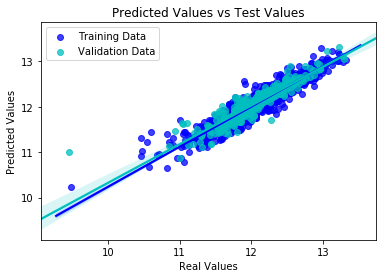

In [113]:
# Scatterplot of Predictions Vs. Actual Values
sns.regplot(y = y_pred_train, x = y_train, color = 'blue', label = 'Training Data', scatter_kws={'alpha':0.75})
sns.regplot(y = y_pred, x = y_test, color = 'c', label = 'Validation Data', scatter_kws={'alpha':0.75})
plt.title('Predicted Values vs Test Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.legend(loc = 'upper left')

Text(0.5, 0, 'Predicted Values')

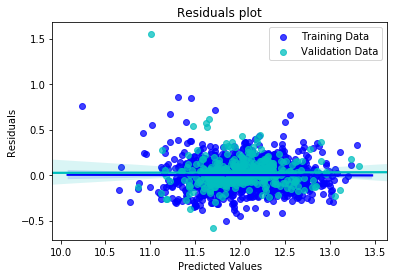

In [114]:
# Plotting Residuals
sns.regplot(x = y_pred_train, y = y_pred_train - y_train, label = 'Training Data', color = 'blue', scatter_kws={'alpha':0.75})
sns.regplot(x = y_pred, y = y_pred - y_test, label = 'Validation Data', color = 'c', scatter_kws={'alpha':0.75})
plt.legend(loc = 'best')
plt.title('Residuals plot')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')

Codes below are for kaggle submission

In [115]:
# y_pred_testr2 = ridge_model.predict(test_cleaned_encode2)
# y_pred_testr2 = np.exp(y_pred_testr2)
# print(y_pred_testr2.shape)
# print(y_pred_testr2.mean())
# y_pred_testr2 = pd.DataFrame(y_pred_testr2)
# final_kaggle = y_pred_testr2.join(test['Id'], how='outer')
# final_kaggle = final_kaggle[['Id', 0]]
# final_kaggle.columns = ['Id','SalePrice']
# print(final_kaggle)
# final_kaggle.to_csv('sy_final_kaggle2.csv',index=False)

## Business Recommendation

- Which features appear to add the most value to a home?
- Which features hurt the value of a home the most?
- What are things that homeowners could improve in their homes to increase the value?
- What neighborhoods seem like they might be a good investment?
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?

From the coefficients of the ridge model with 15 features, it is not surprisingly that houses with larger total square feet, better overall quality and in Crawford neighbourhood will fetch higher prices. Also, houses which are newer (build on a later year) would be sold for a higher price.

On the other hand, a house's functionality that has been labelled as salvage only is the strongest predictor that is negatively correlated to the sale price. Similiarly, houses with fair kitchen quality would also hurt the prices of houses. Houses which are townhosue inside unit also correlated negatively with sale prices.

Since qualities such as total square feet and neighbourhood cannot be changed, home owners can consider maintaining the quality, condition or functionality of their houses well to increase the value of their houses. Also, if they have plans to sell their houses, it may be better to sell them when their houses are still relatively new (i.e. year built is quite recent) as newer flats would contribute to a higher sale price.

From our model, we can see that houses in Crawford neighbourhood would fetch higher sale prices while those in Meadow Village would result in a lower sale price.



### Limitations & Future Work

Limitation of this model is that it can't be generalize to other cities. As we were predicting the sale prices of houses in Ames, feature such as neighbourhood was included in building the model. As a result, this model may not be able to generalize to other cities as the feature neighbourhood is unique to Ames. And furthermore, these variables were important in predicting sale prices of houses in Ames dropping them may result in a model with lower predictive ability. To generalize the model, data like neighbourhood unique to other city could be collected in order to build the regression models.

Furthermore, sale prices of houses may also be affected by external factors such as demand for houses in that area. In addition, variables like days on market may also be a good predictor of sale prices which we can explore in future if we have such data.


In future, further feature engineering can be done to improve the model, for example by implementing polynomial features to see if it could improve the model's score. We can also consider log-transforming some of the positively skewed features in the predictors (1st Flr SF, Bsmt Unf SF, Gr Liv Area, Lot Frontage, Lot Area, Total Bsmt SF, and Garage Area), making their relationship with the target (saleprice) more linear and observe how this could affect our prediction.